In [ ]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.5 MB/s eta 0:00:00


## Table of Contents

* [1. Introduction to the Notebook](#1)
* [2. Google Earth Initialization](#2)
* [3. Area of Interest: South Africa](#3)
* [4. Downloading Images](#4)

<a id="1"></a>
## 1. Introduction to the Notebook

<font size="3">  

Google earth engine is a platform for Geospatial data analysis from Google. It has data from many different satellites including the Sentinel from European Space Agency. I mostly learnt syntax and imported several code snippets from google developer site:  
[https://developers.google.com/earth-engine/tutorials/community/explore](http://)

ere, I'm trying to use the Google Earth engine to retrieve sentinel-1 and sentinel-2 data relating to the CAELLUM spreadscheet of flooding in the South African region.

</p>

In [ ]:
### Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling

VV and VH backscatter polarization refer to the polarization of the radar waves that are transmitted and received by a satellite sensor. In the case of VV polarization, the electric field of the radar wave is oriented vertically (along the vertical axis), while in the case of VH polarization, the electric field is oriented horizontally (along the horizontal axis).

A time series of backscatter refers to a series of measurements of backscatter coefficients at different points in time. The backscatter coefficient is a measure of how much of the radar energy is reflected back to the sensor.

A time series of backscatter provides important information about the evolution of the surface features over time. For example, changes in the backscatter coefficients can indicate changes in the surface roughness, vegetation, soil moisture, and other geophysical properties. These changes can provide valuable information for monitoring the environment, natural resources, and the impact of human activities on the earth's surface.

In [ ]:
### Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A

### import libraries

In [ ]:
import shutil
import matplotlib.pyplot as plt
import IPython.display as disp
import numpy as np
import pandas as pd
import seaborn as sns
import math
import datetime
import ee
from collections import Counter
import requests
import time

import tifffile as tiff

from IPython.display import FileLink
import geemap
import os
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
import gc

<a id="2"></a>
### Google Earth Initialization

<font size="3">
We need to use Earth Engine Authenticate and Initialize functions before using its other functionality.
More on these functions: [https://developers.google.com/earth-engine/apidocs/ee-authenticate](http://).

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Kyz1jIb8LrH-9b8E2SvbLD32-w68Fp0THqS_Nz3TsDo&tc=czeoRI8YEUDC1Nm1UR9QY2ydnGXXo7PA2I2I2vCzG3s&cc=OKWKatn61cabjgqC2PrsA_0wt_udyRKvaS9PIp18NgM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXksbSO-lAqo-sqU4qrqWXXAHOlZjezBvN22b7hWSTFn4qoyPE1Ftr0

Successfully saved authorization token.


In [ ]:
def intersection_dates(lst_dates_1, lst_dates_2):
    return list(set(lst_dates_1) & set(lst_dates_2))

def human_readable_dates(dates):
    readable_dates = [datetime.datetime.fromtimestamp(int(dat) / 1000).strftime("%Y-%m-%d") for dat in dates]
    readable_dates = list(reversed(readable_dates))
#     readable_dates = list(dict.fromkeys(readable_dates))
    return readable_dates

In [ ]:
Caelum_df = pd.read_csv('./CAELUM_2022.csv')
Caelum_df['End Date'] = Caelum_df['End Date'].fillna(Caelum_df['Start Date'])

print(Caelum_df.shape)

(1917, 14)


In [ ]:
essential_columns = ['Latitude', 'Longitude', 'Uniq_ID', 'Start Date', 'End Date',
       'Folder Name']

In [ ]:
CaelumTrueEvents_df = Caelum_df[pd.to_datetime(Caelum_df['Start Date'])>=pd.to_datetime('2017-03-28')].copy()

CaelumTrueEvents_df['Folder Name'] = "417 GeoPoints since 2017"

CaelumTrueEvents_df = CaelumTrueEvents_df[essential_columns].drop_duplicates()

CaelumTrueEvents_df.reset_index(drop=True, inplace=True)
display(Caelum_df.shape, CaelumTrueEvents_df.shape, CaelumTrueEvents_df.tail(3))

(1917, 14)

(417, 6)

,Latitude,Longitude,Uniq_ID,Start Date,End Date,Folder Name
414,-31.218485,29.621356,1915,2023/03/23,2023/03/27,417 GeoPoints since 2017
415,-31.748514,28.744481,1916,2023/03/23,2023/03/27,417 GeoPoints since 2017
416,-31.633409,29.528064,1917,2023/03/23,2023/03/27,417 GeoPoints since 2017


In [ ]:
CaelumMostCommon_df = Caelum_df[['Uniq_ID','Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).count()

CaelumMostCommon_df = CaelumMostCommon_df[CaelumMostCommon_df.Uniq_ID>5]
CaelumMostCommon_df = Caelum_df.merge(CaelumMostCommon_df.reset_index(drop=False).drop('Uniq_ID', axis=1))

CaelumMostCommon_df['Uniq_ID'] = np.nan
CaelumMostCommon_df['Start Date'] = pd.to_datetime('2022-02-01')
CaelumMostCommon_df['End Date'] = pd.to_datetime('2024-01-01')

CaelumMostCommon_df['Folder Name'] = "49 most common GeoPoints [2022-2023]"

CaelumMostCommon_df = CaelumMostCommon_df[essential_columns].drop_duplicates()

CaelumMostCommon_df.reset_index(drop=True, inplace=True)
display(Caelum_df.shape, CaelumMostCommon_df.shape, CaelumMostCommon_df.tail(3))

(1917, 14)

(49, 6)

,Latitude,Longitude,Uniq_ID,Start Date,End Date,Folder Name
46,-25.57,30.53,NaN,2022-02-01,2024-01-01,49 most common GeoPoints [2022-2023]
47,-25.86,28.18,NaN,2022-02-01,2024-01-01,49 most common GeoPoints [2022-2023]
48,-26.16,28.08,NaN,2022-02-01,2024-01-01,49 most common GeoPoints [2022-2023]


In [ ]:
ExtraGeoPoints_df = pd.DataFrame([])

lat_lon = [-27.7268, 26.0598,
            -29.5471, 25.2629,
            -29.4583, 28.0989,
            -30.3723, 29.1008,
            -32.3149, 24.6117,
            -30.3110, 19.8129,
            -34.0175, 19.1567,
            -33.7285, 19.4270,
            -34.7085, 19.9279,
            -34.4712, 20.3718,
            -34.2746, 18.9633,
            -33.1583, 19.1611]

ExtraGeoPoints_df['Latitude'] = lat_lon[0:len(lat_lon):2]
ExtraGeoPoints_df['Longitude'] = lat_lon[1:len(lat_lon):2]

ExtraGeoPoints_df['Uniq_ID'] = np.nan
ExtraGeoPoints_df['Start Date'] = pd.to_datetime('2022-02-01')
ExtraGeoPoints_df['End Date'] = pd.to_datetime('2024-01-01')

ExtraGeoPoints_df['Folder Name'] = "12 extra GeoPoints [2022-2023]"
display(Caelum_df.shape, ExtraGeoPoints_df.shape, ExtraGeoPoints_df.sample(3))

(1917, 14)

(12, 6)

,Latitude,Longitude,Uniq_ID,Start Date,End Date,Folder Name
1,-29.5471,25.2629,NaN,2022-02-01,2024-01-01,12 extra GeoPoints [2022-2023]
5,-30.3110,19.8129,NaN,2022-02-01,2024-01-01,12 extra GeoPoints [2022-2023]
11,-33.1583,19.1611,NaN,2022-02-01,2024-01-01,12 extra GeoPoints [2022-2023]


In [ ]:
# Generate a DataFrame of events and wanted dates
def intersection_dates_df(df):
    ee.Initialize()
    S2_SR_inner_SAR_dataset = pd.DataFrame([])
    event_uniq_id = 0
    for geo_point_idx in df.T:
        folder_name = df.iloc[geo_point_idx]['Folder Name']
        caelum_uniq_id = df.iloc[geo_point_idx]['Uniq_ID']
        caelum_start_date = df.iloc[geo_point_idx]['Start Date']
        caelum_end_date = df.iloc[geo_point_idx]['End Date']
        geo_point_lat = df.iloc[geo_point_idx]['Latitude']
        geo_point_lon = df.iloc[geo_point_idx]['Longitude']

        start_a_month_before_event = pd.to_datetime(df.iloc[geo_point_idx]['Start Date']) - pd.to_timedelta(np.ceil(30), unit="D")
        end_a_month_after_event = pd.to_datetime(df.iloc[geo_point_idx]['End Date']) + pd.to_timedelta(np.ceil(30), unit="D")

        # Define the location of interest.
        u_poi = ee.Geometry.Point(geo_point_lon, geo_point_lat)

        # Define a region of interest with a buffer zone of 10000 km around the point.
        roi_filter = u_poi.buffer(1e4).bounds()

        date_filter = ee.Filter.date(start_a_month_before_event, end_a_month_after_event)


        S2_SR_img_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterBounds(roi_filter)\
                    .filter(date_filter)\
                    .sort('system:time_start', False)

        # Print the number of images in the first filtered collection.
        # print('Number of S2_SR images:', S2_SR_img_collection.size().getInfo())

        # Get the dates of the images in the filtered collection
        dates = S2_SR_img_collection.aggregate_array("system:time_start").getInfo()

        # Convert the dates from Unix time to human-readable format
        S2_SR_readable_dates = human_readable_dates(dates)


        SAR_img_collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
                    .filterBounds(roi_filter)\
                    .filter(date_filter)\
                    .sort('system:time_start', False)

        # Print the number of images in the second filtered collection.
        # print('Number of SAR images:', SAR_img_collection.size().getInfo())

        # Get the dates of the images in the filtered collection
        dates = SAR_img_collection.aggregate_array("system:time_start").getInfo()

        # Convert the dates from Unix time to human-readable format
        SAR_readable_dates = human_readable_dates(dates)


        # Calculate the number of images in the 2 filtered collection.
        S2_SR_inner_SAR_dates = intersection_dates(S2_SR_readable_dates, SAR_readable_dates)
        # print(f"Number of intersected dates: {len(S2_SR_inner_SAR_dates)} \n")
        if len(S2_SR_inner_SAR_dates) > 0:
            S2_SR_inner_SAR_subset = pd.DataFrame([])

            S2_SR_inner_SAR_subset.loc[:,"satellites dates"] = S2_SR_inner_SAR_dates

            S2_SR_inner_SAR_subset.loc[:,"CAELUM Uniq_ID"] = caelum_uniq_id
            S2_SR_inner_SAR_subset.loc[:,"CAELUM Start Date"] = caelum_start_date
            S2_SR_inner_SAR_subset.loc[:,"CAELUM End Date"] = caelum_end_date

            S2_SR_inner_SAR_subset.loc[:,"Start Date"] = start_a_month_before_event
            S2_SR_inner_SAR_subset.loc[:,"End Date"] = end_a_month_after_event

            S2_SR_inner_SAR_subset.loc[:,"Longitude"] = geo_point_lon
            S2_SR_inner_SAR_subset.loc[:,"Latitude"] = geo_point_lat

            S2_SR_inner_SAR_subset.loc[:,"Folder Name"] = folder_name
            S2_SR_inner_SAR_subset.loc[:,"Event Uniq_ID"] = event_uniq_id

            event_uniq_id += 1
            S2_SR_inner_SAR_dataset = pd.concat([S2_SR_inner_SAR_dataset, S2_SR_inner_SAR_subset])

    S2_SR_inner_SAR_dataset['Image Id'] = np.arange(len(S2_SR_inner_SAR_dataset)).astype(str)

    return S2_SR_inner_SAR_dataset

In [ ]:
%%time

CaelumTrueEvents_inner_Dataset = intersection_dates_df(CaelumTrueEvents_df) # DataFrame of true events list (events started after 2017, the start date of S2_SR_HARMONIZED satellite)
CaelumMostCommon_inner_Dataset = intersection_dates_df(CaelumMostCommon_df) # DataFrame of most common flooding areas extracted from the true events
ExtraGeoPoints_inner_Dataset = intersection_dates_df(ExtraGeoPoints_df) # DataFrame of extra areas extracted from WordView flooding dataset

# Concatenate the three Datasets
IntersectionDatesDataset = pd.concat([CaelumTrueEvents_inner_Dataset, CaelumMostCommon_inner_Dataset, ExtraGeoPoints_inner_Dataset])

CPU times: user 10.8 s, sys: 338 ms, total: 11.1 s
Wall time: 2min 35s


In [ ]:
# Convert folder names to integers, then concatenate them with event and image indices.
le = LabelEncoder()
folder_names = le.fit_transform(IntersectionDatesDataset['Folder Name'])

IntersectionDatesDataset['Event Uniq_ID'] = IntersectionDatesDataset['Event Uniq_ID'].astype(str) +'_'+ folder_names.astype(str)
IntersectionDatesDataset['Image Id'] = IntersectionDatesDataset['Image Id'].astype(str) +'_'+ folder_names.astype(str)

In [ ]:
# Create empty folders to contain images from each of the 3 concatenated DataFrames (CaelumTrueEvents_inner_Dataset, CaelumMostCommon_inner_Dataset, ExtraGeoPoints_inner_Dataset)
for folder in IntersectionDatesDataset['Folder Name'].unique():
    %mkdir '{folder}'
    %mkdir '{folder}/VV'
    %mkdir '{folder}/S2_SR_HARMONIZED'

mkdir: cannot create directory ‘417 GeoPoints since 2017’: File exists
mkdir: cannot create directory ‘417 GeoPoints since 2017/VV’: File exists
mkdir: cannot create directory ‘417 GeoPoints since 2017/S2_SR_HARMONIZED’: File exists
mkdir: cannot create directory ‘49 most common GeoPoints [2022-2023]’: File exists
mkdir: cannot create directory ‘49 most common GeoPoints [2022-2023]/VV’: File exists
mkdir: cannot create directory ‘49 most common GeoPoints [2022-2023]/S2_SR_HARMONIZED’: File exists
mkdir: cannot create directory ‘12 extra GeoPoints [2022-2023]’: File exists
mkdir: cannot create directory ‘12 extra GeoPoints [2022-2023]/VV’: File exists
mkdir: cannot create directory ‘12 extra GeoPoints [2022-2023]/S2_SR_HARMONIZED’: File exists


In [ ]:
# Download images by the fishnet cells in parallel.
"""
fishnet = geemap.fishnet(roi_filter, h_interval=4.0, v_interval=4.0, delta=0.5)

geemap.download_ee_image_tiles_parallel(
    sar_tile, fishnet, out_dir='./', scale=35)
"""

"\nfishnet = geemap.fishnet(roi_filter, h_interval=4.0, v_interval=4.0, delta=0.5)\n\ngeemap.download_ee_image_tiles_parallel(\n    sar_tile, fishnet, out_dir='./', scale=35)\n"

In [ ]:
def maskS2clouds(image) :
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)\
             .add(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(1e3)

def mask_edge(image):
    edge = image.lt(-30.0)
    masked_image = image.mask().And(edge.Not())

    return image.updateMask(masked_image)

def ndvi_image(image):
    # Compute NDVI for each image
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')

    # Add acquisition date as a band to the image
    date = ee.Date(image.get('system:time_start')).format('YYYYMMdd')
    dateBand = ee.Image(ee.Number.parse(date)).toInt().rename('date')

    return image.addBands(ndvi).addBands(dateBand)
# Create function for downloading GeoTiff images in workspace
def save_tiff_localy(image, filename, region, file_per_band, scale):
    # Export an image localy
    geemap.ee_export_image(image,
                        filename=filename,
                        region=region,
                        # False : Exporting all bands as a single image
                        # True: Exporting each band as one image
                        file_per_band=file_per_band,
                        scale=scale # The scale to do stratified sampling
                           )
# Create function for downloading GeoTiff images to the Drive space
def save_tiff_to_drive(image, description, region, file_per_band, scale):
     # Export an image
    geemap.ee_export_image_to_drive(image,
                    description=description,
                    folder='SA Collection',
                    region=region,
                    # False : Exporting all bands as a single image
                    # True: Exporting each band as one image
                    file_per_band=file_per_band,
                    scale=scale
                                    )

# Create function for downloading images with Png and Jpeg formats in workspace
def save_image_localy(image, param_Vis, width, image_path):
            # image.getThumbURL() method is used to select the pixels
            image_url = image.getThumbUrl(param_Vis)
            #display(disp.Image(url=image_url, width=width))
            # Handle downloading the actual pixels.
            response = requests.get(image_url, stream=True)
            if response.status_code != 200:
                response.raise_for_status()
            with open(image_path, 'wb') as out_file:
                        shutil.copyfileobj(response.raw, out_file)
            del response

def download_tiles(df_row, tile_formats=["png", "tif"]):
    # Initialize GEE to use the high-volume endpoint
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

    df_row['Image Format'] = tile_formats

    for tile_format in tile_formats:
        # Extract information about the event in question
        folder_name = df_row['Folder Name'] # one of the 3 main Folders (true events list, list of most common flooding areas extracted from the true events, and a list of extra areas extracted from WordView flooding dataset)
        tile_id = df_row['Image Id']
        event_uniq_id = df_row['Event Uniq_ID']
        event_date = df_row['satellites dates']
        event_lat = df_row['Latitude']
        event_lon = df_row['Longitude']

        event_date = pd.to_datetime(event_date)
        one_day_duration = event_date + pd.to_timedelta(np.ceil(1), unit="D")
        date_filter = ee.Filter.date(event_date, one_day_duration)

        # Define the location of interest.
        u_poi = ee.Geometry.Point(event_lon, event_lat)

        # Define a region of interest with a buffer zone of 10000 km around the point.
        roi_filter = u_poi.buffer(1e4).bounds()

        # Define the first images source
        S2_SR_img_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                          .filterBounds(roi_filter)\
                          .filter(date_filter)\
                          .sort('system:time_start', False)\
                          .map(maskS2clouds)

        # Define the second images source
        SAR_img_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                        .filterBounds(roi_filter) \
                        .filter(date_filter)\
                        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                        .map(mask_edge)

        SAR_tile = SAR_img_collection.first().select(['VV'])
        S2_SR_tile = S2_SR_img_collection.mean().select(['B4', 'B3', 'B2'])

        # Clip the image by region of interrest in South Africa.
        SAR_tile = SAR_tile.clip(roi_filter)
        S2_SR_tile = S2_SR_tile.clip(roi_filter)

        # Set parameters
        # If you want the exported images to have coordinate system,
        # change format to GEO_TIFF. Otherwise, you can use png or jpg formats.
        s2_sr_param_Vis = {
                      'min': 0,
                      'max': 3,
                      'gamma': 1.1,
                      'region': roi_filter, # Define the Region of Interest (ROI)
                      'dimensions': 512, # The dimension of each image chip
                      'format': tile_format # # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
                              }

        sar_param_Vis = {
                      'min': -25,
                      'max': 5,
                      'region': roi_filter, # Define the Region of Interest (ROI)
                      'dimensions': 512, # The dimension of each image chip
                      'format': 'png', # # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
                      'palette': ['black', 'white']
                            }

        # Download images
        if tile_format in ["png", "jpg"]:
            # Create the URL associated with the styled image data.
            s2_sr_path = os.path.normpath(f'./{folder_name}/S2_SR_HARMONIZED/{event_uniq_id}_{tile_id}.{tile_format}')
            sar_path = os.path.normpath(f'./{folder_name}/VV/{event_uniq_id}_{tile_id}.{tile_format}')

             # Save only the output directory without the image format. Default to the current working directly
            df_row[f'SAR {tile_format} Path'] = sar_path[:-4]
            df_row[f'S2_SR {tile_format} Path'] = s2_sr_path[:-4]

            #file_per_band=True, Exporting each band as one image
            #file_per_band=False, Exporting all bands as a single image
            save_image_localy(SAR_tile, sar_param_Vis, 512, sar_path)
            save_image_localy(S2_SR_tile, s2_sr_param_Vis, 512, s2_sr_path)

        # Download GeoTiff bands as a single image or separate images
        elif tile_format == "tif":
            # Create the URL associated with the styled image data.
            s2_sr_path = os.path.normpath(f'./{folder_name}/S2_SR_HARMONIZED/{event_uniq_id}_{tile_id}.{tile_format}')
            sar_path = os.path.normpath(f'./{folder_name}/VV/{event_uniq_id}_{tile_id}.{tile_format}')
            # Save only the output directory without the image format. Default to the current working directly
            df_row[f'SAR {tile_format} Path'] = sar_path[:-4]
            df_row[f'S2_SR {tile_format} Path'] = s2_sr_path[:-4]

            # Export an image localy
            #file_per_band=True, Exporting each band as separate image
            #file_per_band=False, Exporting all bands as a single image
            save_tiff_localy(SAR_tile, sar_path, roi_filter, False, 35)
            save_tiff_localy(S2_SR_tile, s2_sr_path, roi_filter, False, 35)

            ## Export an image to Google Drive
            # save_tiff_to_drive(SAR_tile, "S1_GRD", roi_filter, False, 35)
            # save_tiff_to_drive(S2_SR_tile, "S2_SR_HARMONIZED", roi_filter, False, 35)

    return df_row

In [ ]:
gc.collect()

0

In [ ]:
IntersectionDatesDataset.shape

(2490, 11)

In [ ]:
limited = True # Try downloading only the first 30 rows
if limited==False:
  limit=-1 #download all the possible images
else:
  limit=30

In [ ]:
%%time

IntersectionDatesDataset = IntersectionDatesDataset.reset_index(drop=True)

# Downloading images in parallel
TilesDataset = Parallel(n_jobs=-1,  verbose=1)( #backend="threading",
    delayed(download_tiles)(IntersectionDatesDataset.iloc[row_idx], tile_formats=["png", "tif"]) for row_idx in IntersectionDatesDataset.index[:limit])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 681 ms, sys: 118 ms, total: 799 ms
Wall time: 45.4 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.4s finished


In [ ]:
SouthAfricaDataCollection = pd.concat(TilesDataset, axis=1).T

SouthAfricaDataCollection.to_csv('SA Data Collection.csv', index=False)
SouthAfricaDataCollection.tail(2)

,satellites dates,CAELUM Uniq_ID,CAELUM Start Date,CAELUM End Date,Start Date,End Date,Longitude,Latitude,Folder Name,Event Uniq_ID,Image Id,Image Format,SAR png Path,S2_SR png Path
28,2019-02-08,1525.0,2019/03/10,2019/03/10,2019-02-08,2019-04-09,30.97,-29.74,417 GeoPoints since 2017,11_1,28_1,[png],417 GeoPoints since 2017/VV/11_1_28_1,417 GeoPoints since 2017/S2_SR_HARMONIZED/11_1...
29,2019-03-25,1525.0,2019/03/10,2019/03/10,2019-02-08,2019-04-09,30.97,-29.74,417 GeoPoints since 2017,11_1,29_1,[png],417 GeoPoints since 2017/VV/11_1_29_1,417 GeoPoints since 2017/S2_SR_HARMONIZED/11_1...


In [ ]:
for i in os.walk('./417 GeoPoints since 2017/S2_SR_HARMONIZED/'):
    print(i)
    break

('./417 GeoPoints since 2017/S2_SR_HARMONIZED/', [], ['31_1_80_1.tif', '34_1_86_1.png', '4_1_9_1.tif', '42_1_108_1.tif', '26_1_66_1.png', '20_1_52_1.png', '23_1_59_1.png', '25_1_63_1.png', '4_1_12_1.png', '38_1_97_1.png', '8_1_20_1.tif', '41_1_105_1.png', '35_1_89_1.png', '28_1_70_1.png', '14_1_36_1.png', '44_1_112_1.png', '49_1_126_1.tif', '51_1_134_1.tif', '23_1_58_1.tif', '18_1_46_1.png', '30_1_76_1.png', '24_1_61_1.tif', '31_1_78_1.tif', '24_1_62_1.png', '21_1_54_1.png', '16_1_41_1.png', '40_1_102_1.png', '49_1_127_1.tif', '47_1_119_1.tif', '15_1_39_1.tif', '11_1_29_1.tif', '19_1_50_1.png', '43_1_110_1.tif', '45_1_115_1.png', '38_1_97_1.tif', '0_1_1_1.png', '48_1_121_1.tif', '38_1_99_1.png', '49_1_125_1.png', '27_1_69_1.png', '36_1_91_1.tif', '16_1_40_1.tif', '37_1_94_1.tif', '42_1_109_1.tif', '18_1_49_1.png', '32_1_83_1.png', '29_1_74_1.tif', '2_1_3_1.tif', '10_1_25_1.png', '3_1_6_1.tif', '33_1_85_1.png', '7_1_16_1.png', '51_1_137_1.tif', '28_1_70_1.tif', '16_1_42_1.png', '47_1_11

(573, 687, 3)

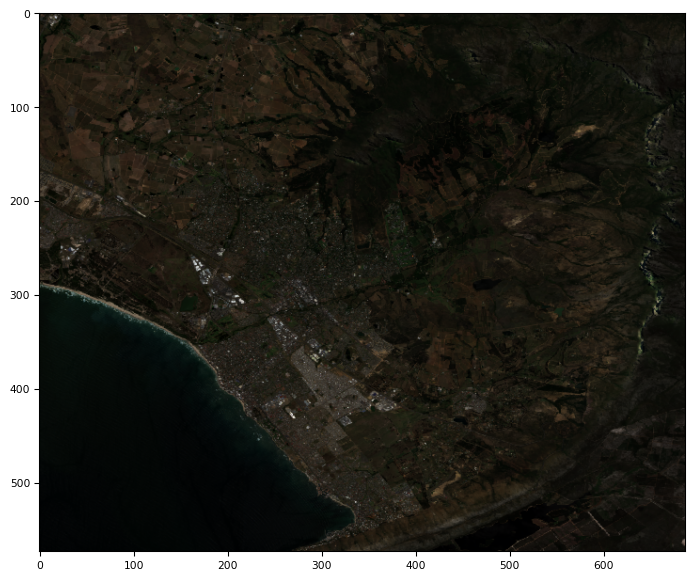

In [ ]:
tif_path = './417 GeoPoints since 2017/S2_SR_HARMONIZED/43_1_110_1.tif'
tfile = tiff.imread(tif_path)
display(tfile.shape)
tiff.imshow(tfile)
del tfile

In [ ]:
for i in os.walk('./417 GeoPoints since 2017/VV/'):
    print(i)
    break

('./417 GeoPoints since 2017/VV/', [], ['31_1_80_1.tif', '34_1_86_1.png', '4_1_9_1.tif', '42_1_108_1.tif', '26_1_66_1.png', '20_1_52_1.png', '23_1_59_1.png', '25_1_63_1.png', '4_1_12_1.png', '38_1_97_1.png', '8_1_20_1.tif', '41_1_105_1.png', '35_1_89_1.png', '28_1_70_1.png', '14_1_36_1.png', '44_1_112_1.png', '49_1_126_1.tif', '51_1_134_1.tif', '23_1_58_1.tif', '18_1_46_1.png', '30_1_76_1.png', '24_1_61_1.tif', '31_1_78_1.tif', '24_1_62_1.png', '21_1_54_1.png', '16_1_41_1.png', '40_1_102_1.png', '49_1_127_1.tif', '47_1_119_1.tif', '15_1_39_1.tif', '11_1_29_1.tif', '19_1_50_1.png', '43_1_110_1.tif', '45_1_115_1.png', '38_1_97_1.tif', '0_1_1_1.png', '48_1_121_1.tif', '38_1_99_1.png', '49_1_125_1.png', '27_1_69_1.png', '36_1_91_1.tif', '16_1_40_1.tif', '37_1_94_1.tif', '42_1_109_1.tif', '18_1_49_1.png', '32_1_83_1.png', '29_1_74_1.tif', '2_1_3_1.tif', '10_1_25_1.png', '3_1_6_1.tif', '33_1_85_1.png', '7_1_16_1.png', '51_1_137_1.tif', '28_1_70_1.tif', '16_1_42_1.png', '47_1_117_1.tif', '31_

(593, 592)

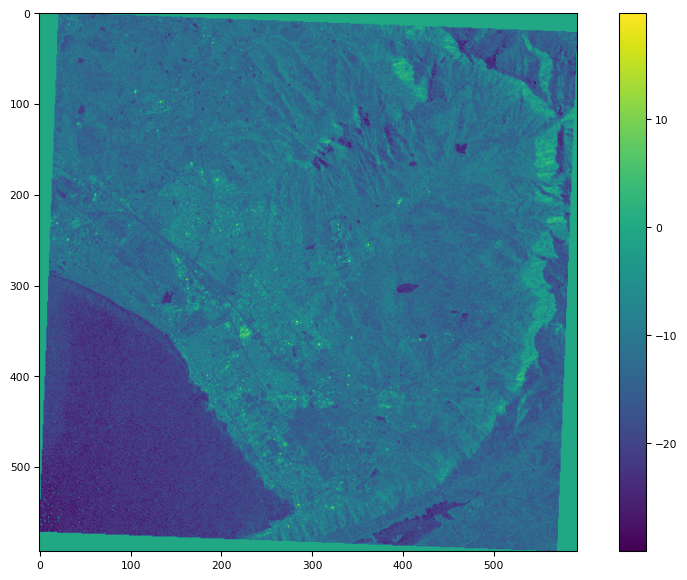

In [ ]:
tif_path = './417 GeoPoints since 2017/VV/43_1_110_1.tif'
tfile = tiff.imread(tif_path)
display(tfile.shape)
tiff.imshow(tfile)
del tfile